In [9]:
%who

ConfusionMatrixDisplay	 FastICA	 LogisticRegression	 MLPClassifier	 StandardScaler	 all_data	 all_metadata	 band_power	 check_random_state	 
confusion_matrix	 cross_val_score	 data	 data_idx	 data_path	 f	 f1	 f2	 f_bin	 
f_bins	 f_idx	 features	 fetch_openml	 itertools	 metadata	 metadata_path	 np	 os	 
pairwise_tukeyhsd	 pd	 plt	 psd	 scipy	 signal	 sleep_data	 sleep_metadata	 sleep_stages	 
sp	 stage	 train_test_split	 wake_data	 wake_metadata	 wake_stages	 


In [27]:
import scipy.io
import scipy.signal as signal
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mat73

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FastICA

import itertools
import scikit_posthocs as sp


In [2]:
# stage_names = ['Art', 'A', 'W', 'N1',  'N2', 'N3', 'REM']
sleep_stages = ['N1',  'N2', 'N3', 'REM']
wake_stages = ['A',  'W']


# data_path = '../data/merged_data_heart_artifact_clean.mat'
# metadata_path = '../data/merged_metadata_heart_artifact_clean.csv'
data_path = '../data/merged_data_2023_05_09.mat'
metadata_path = '../data/merged_metadata_2023_05_09.csv'
all_metadata = pd.read_csv(metadata_path)  


In [3]:
all_data = mat73.loadmat(data_path)
all_data = all_data['data']

In [13]:
# # Select the 4 sleep stages
# data_idx = np.zeros_like(all_metadata['sleep_stage'])
# for stage in sleep_stages:
#     data_idx = data_idx | (all_metadata['sleep_stage'] == stage)

# data = all_data[data_idx, :]
# metadata = all_metadata[data_idx]
# metadata = metadata.reset_index(drop=True)

In [4]:
# Split data into sleep and wake
data_idx = np.zeros_like(all_metadata['sleep_stage'])

for stage in sleep_stages:
    data_idx = data_idx | (all_metadata['sleep_stage'] == stage)
sleep_data = all_data[data_idx, :]
sleep_metadata = all_metadata[data_idx]
sleep_metadata = sleep_metadata.reset_index(drop=True)
sleep_metadata['sleep_stage'] = 'S'
sleep_metadata['label'] = 0

data_idx = np.zeros_like(all_metadata['sleep_stage'])
for stage in wake_stages:
    data_idx = data_idx | (all_metadata['sleep_stage'] == stage)
wake_data = all_data[data_idx, :]
wake_metadata = all_metadata[data_idx]
wake_metadata = wake_metadata.reset_index(drop=True)
wake_metadata['sleep_stage'] = 'W'
wake_metadata['label'] = 1

data = np.vstack([sleep_data, wake_data])
metadata = pd.concat([sleep_metadata, wake_metadata], axis=0, ignore_index=True)


In [5]:
f, psd = signal.periodogram(data, 500)


In [24]:
f1 = np.arange(1,50)
f2 = np.arange(2,51)
f_bins = np.transpose(np.vstack((f1,f2)))
# f_bins = np.array([[1, 4], [4, 7], [7, 12], [12, 30], [30, 50]])
features = np.array([])
for f_bin in f_bins:
    f_idx = np.where((f >= f_bin[0]) & (f < f_bin[1]))[0]
    
    band_power = np.mean(psd[:, f_idx], axis=1)
    features = np.vstack((features, band_power)) if features.size else band_power
    
features = np.transpose(features)

In [25]:
scaler = StandardScaler()
z = np.abs(scaler.fit_transform(features))

outlier_idx = np.any(np.abs(z) > 3, axis=1) 
features_clean = np.delete(features, outlier_idx, axis=0)

x = np.where(outlier_idx)
metadata_clean = metadata.drop(x[0])


In [12]:
subject_idx = metadata_clean['subject'] == 'Buster'


for i_bin in range(f_bins.shape[0]):
    
    data_tuple = tuple()
    
    for stage in ['S', 'W']:
        stage_idx = metadata_clean['sleep_stage'] == stage
        data_idx = subject_idx & stage_idx
        
        stage_feaures = features_clean[data_idx, i_bin]
        data_tuple += (stage_feaures,)
    
    stats = scipy.stats.f_oneway(*data_tuple)
    print('p-value = {:.1E}'.format(stats[1]))
    fig, ax = plt.subplots()
    ax.boxplot(data_tuple,showfliers=True)
    ax    
ax.set_xticklabels(['S', 'W'])


NameError: name 'stage_names' is not defined

In [30]:
subject_idx = metadata['subject'] == 'Buster'

for i_bin in range(f_bins.shape[0]):

    df = pd.DataFrame({'score': features[i_bin,subject_idx],
                       'group': metadata['sleep_stage'][subject_idx]}) 

    # Perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=df['score'],
                              groups=df['group'],
                              alpha=0.05)
    
#     print(sp.posthoc_dunn(features[:,subject_idx], p_adjust = 'bonferroni'))

    # Display results
#     print(tukey)

(14726, 49)
0.9590386785677645


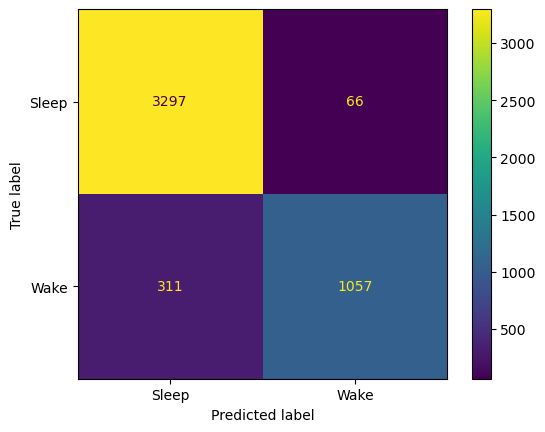

0.9684132846158755


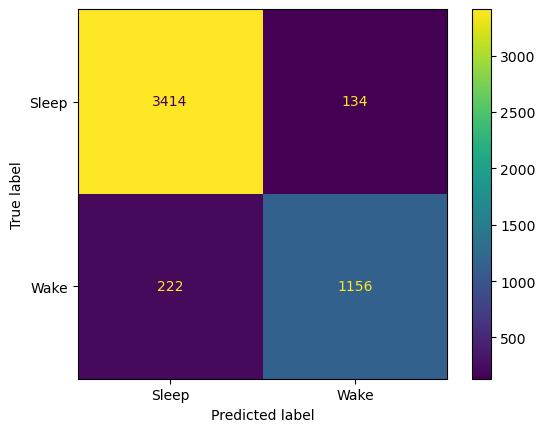

0.9592798094847694


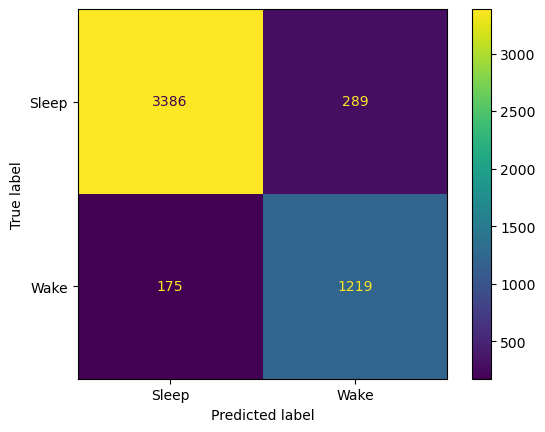

In [51]:
scaler = StandardScaler()

subject_idx =  (metadata_clean['subject'] == 'Buster')
# subject_idx = (metadata_clean['subject'] == 'Keaton') 
subject_idx = (metadata_clean['subject'] == 'Keaton') | (metadata_clean['subject'] == 'Buster')

X_features = features_clean[subject_idx,:]
X_metadata = metadata_clean[subject_idx]

metalabels = np.zeros((X_features.shape[0]))
metalabels[X_metadata['sleep_stage'] == 'W'] = 1
# print(metalabels)
# metalabels = X_metadata['sleep_stage']
# metalabels = np.random.permutation(metalabels)
records = np.unique(X_metadata['record'])
print(X_features.shape)
for i_record, test_record in enumerate(records):
    
    train_idx = X_metadata['record'] != test_record
    test_idx = X_metadata['record'] == test_record
    
    X_train = X_features[train_idx,:]
    X_test = X_features[test_idx,:]
  
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train = metalabels[train_idx]
    y_test = metalabels[test_idx]

    # clf = LogisticRegression(penalty="l1", solver="saga", tol=0.01, class_weight='balanced')
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,5), random_state=1, max_iter=100000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_est = clf.predict_proba(X_test)

    # print(y_est[:,0])
    score = clf.score(X_test, y_test)
    # print(score)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_est[:,1], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(auc)
    normalize = None
    cm = metrics.confusion_matrix(y_test, y_pred, normalize=normalize)
    
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Sleep','Wake'))
    disp.plot()
    plt.show()





In [37]:

data_path = '../data/heat_artifact_data/Keaton_CR123_Nuit1_2021_09_24.mat'
data_struct = scipy.io.loadmat(data_path)
data = data_struct['data']
# data = np.transpose(data)

[[ 1.11457203e-06  3.12312372e-06  3.58056266e-06 ... -6.94285496e-07
  -2.83054856e-06 -2.61692226e-06]
 [-4.11066779e-07 -1.67849870e-06 -1.04598767e-06 ...  3.57824063e-06
   1.97604334e-06  3.73846036e-07]
 [ 2.72373541e-06  4.00549325e-06  4.21911955e-06 ...  1.33516442e-06
   2.29648280e-06  1.97604334e-06]
 ...
 [-1.26797471e-06 -1.38439742e-06 -1.65241124e-06 ... -1.71495407e-06
  -2.21633183e-06 -2.35706945e-06]
 [-6.95312938e-07 -6.15061709e-07 -4.76445950e-07 ...  1.18338919e-07
   7.27340481e-07  8.36028773e-07]
 [-8.57420688e-08 -6.30386681e-07 -8.99808100e-07 ... -1.28906092e-06
   2.70408049e-07  1.51934557e-06]]


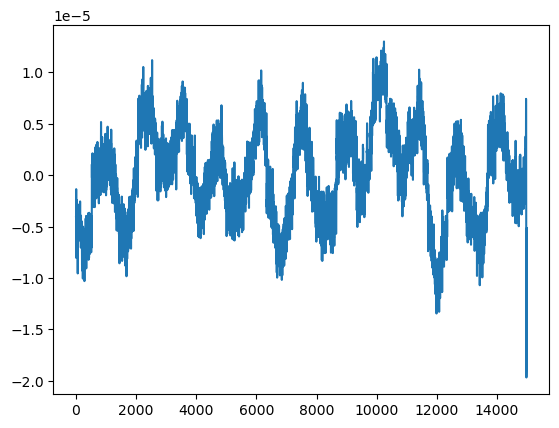

In [8]:





data_segment = data[2000,:]

print(data)
fig, ax = plt.subplots()
ax.plot(data_segment)






In [10]:
a = np.array([1,2,3,4,5,6])
d = np.array([True, False,True, False,True, False])

a[d]


array([1, 3, 5])